# The main implementation of thesis project

# Setting customised library path

In [1]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configuration

In [172]:
image_size = (128, 128)
n_image_channels = 3

image_shape = (*image_size, n_image_channels) #input image shape

proj_dense_dims = (400, 200, ) #the projection head dense dims

batch_size = 128 # sample batch size

n_epochs = 20

temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training

# self-supervised contrastive learning
contrastive_imgaug_params = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}

# for classification
classification_imgaug_params = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

# Preparing the dataset

In [136]:
import tensorflow as tf
from tensorflow import keras

In [137]:
train_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                #subset = "training",
                #validation_split = 0.2,
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                #seed = 2771,
                shuffle = True
                )

Found 30800 files belonging to 154 classes.


In [138]:
test_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                #subset="validation",
                #validation_split = 0.2,
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                #seed = 2771,
                shuffle = True
                )

Found 7700 files belonging to 154 classes.


In [139]:
n_classes = len(train_dataset_.class_names)
n_samples = len(train_dataset_) * batch_size
n_batches = len(train_dataset_)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  30976
n_batches =  121


In [140]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

In [141]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([256, 128, 128, 3])

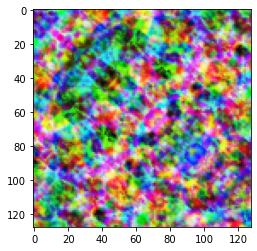

In [142]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

In [14]:
#import matplotlib.pyplot as plt
#import tensorflow as tf
#import tensorflow_datasets as tfds

#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [15]:
# Dataset hyperparameters
#unlabeled_dataset_size = 100000
#labeled_dataset_size = 5000
#image_size = 128
#image_channels = 3

# Algorithm hyperparameters
#num_epochs = 20
#batch_size = 525  # Corresponds to 200 steps per epoch
#width = 128
#temperature = 0.1
#n_classes = 154

# Stronger augmentations for contrastive, weaker ones for supervised training
#contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
#classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [143]:

# Distorts the color distibutions of images
class CustomisedColorAffineLayer(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images




In [171]:

# Image augmentation module
def build_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            #keras.layers.InputLayer(input_shape=(image_size, image_size, image_channels)),
            keras.layers.InputLayer(input_shape=image_shape),
            #preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            preprocessing.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            CustomisedColorAffineLayer(brightness, jitter),
        ]
    )


def visualize_augmentations(n_samples):
    # Sample a batch from a dataset
    #images = next(iter(train_dataset))[0][0][:num_images]
        
    images = next(iter(train_dataset))[0][:n_samples]
    
    #print(images.shape)
    #a=get_augmenter(**contrastive_augmentation)(images)
    
    #print(a.shape)
    
    
    # Apply augmentations
    augmented_images = zip(
        images,
        build_augmenter(**classification_imgaug_params)(images),
        build_augmenter(**contrastive_imgaug_params)(images),
        build_augmenter(**contrastive_imgaug_params)(images),
    )
    
    #print(augmented_images.shape)
    
    #return

    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    
    plt.figure(figsize=(n_samples * 2.2, 4 * 2.2), dpi = 100)
    
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, n_samples, row * n_samples + column + 1)
            plt.imshow(image, vmin=0, vmax=1)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


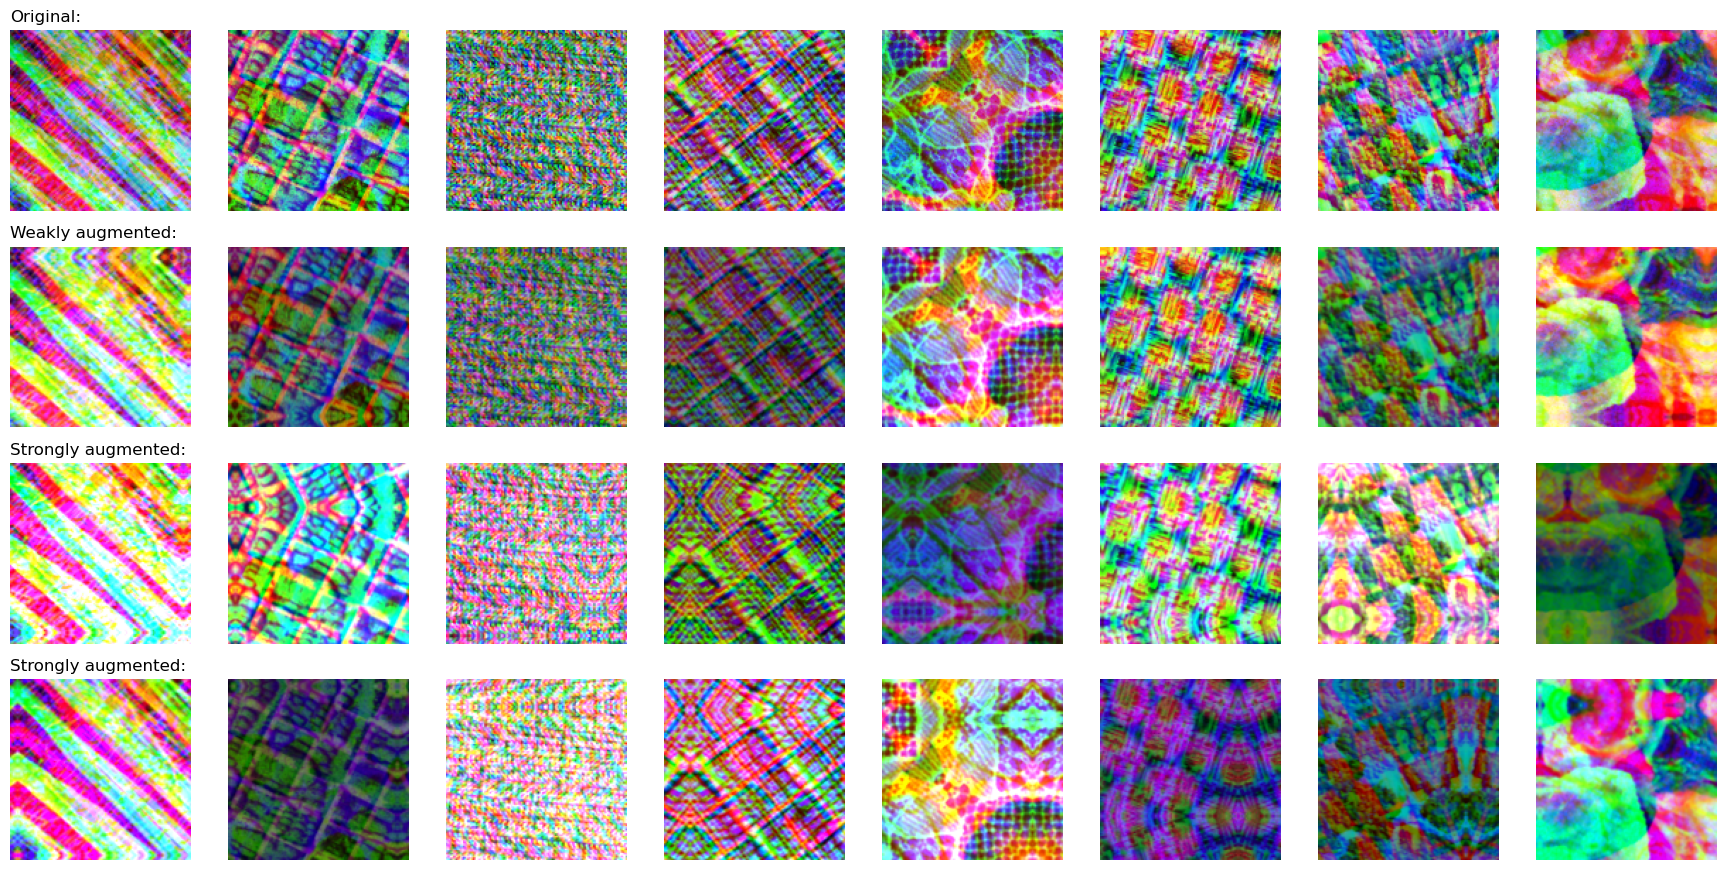

In [145]:
visualize_augmentations(n_samples = 8)

# Simple base encoder

In [167]:
# Define the encoder architecture
def build_simple_encoder():
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape),
            
            layers.Conv2D(32, kernel_size=5, strides=2, activation="relu"),
            #layers.Dropout(0.2),
            
            layers.Conv2D(64, kernel_size=5, strides=2, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, kernel_size=5, strides=2, activation="relu"),
            #layers.Dropout(0.2),
            
            layers.Conv2D(256, kernel_size=5, strides=2, activation="relu"),
            
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Flatten(),
            #layers.BatchNormalization(),
            #layers.Dropout(0.6),
            
            # 500 is good
            layers.Dense(1000, activation="relu"),
        ],
        name="encoder_simple",
    )

# Baseline: Supervised learning with simple encoder

In [93]:
# Baseline supervised training with random initialization
baseline_model_simple = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape = image_shape),
        build_augmenter(**classification_imgaug_params),
        build_simple_encoder(),
        layers.Dense(n_classes),
    ],
    name="baseline_model_simple",
)

baseline_model_simple.compile(
        optimizer = keras.optimizers.Adam(),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

In [94]:
#baseline_model_simple.summary()

In [95]:
images = next(iter(train_dataset))[0]
out = baseline_model_simple.predict(images)
out.shape

(128, 154)

In [96]:
#labels = next(iter(train_dataset))[1]
#labels

In [97]:
#baseline_model_simple.layers[0].output

In [98]:
#baseline_model_simple.layers[-1].output

In [99]:
baseline_simple_history = baseline_model_simple.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    #steps_per_epoch = 100,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 222s 916ms/step - loss: 3.5922 - acc: 0.1816 - val_loss: 25.4525 - val_acc: 0.0065
Epoch 2/20
241/241 [==============================] - 187s 775ms/step - loss: 0.9584 - acc: 0.6928 - val_loss: 9.4737 - val_acc: 0.1023
Epoch 3/20
241/241 [==============================] - 189s 783ms/step - loss: 0.4569 - acc: 0.8470 - val_loss: 2.8901 - val_acc: 0.4421
Epoch 4/20
241/241 [==============================] - 183s 756ms/step - loss: 0.3210 - acc: 0.8923 - val_loss: 2.1376 - val_acc: 0.5784
Epoch 5/20
241/241 [==============================] - 177s 733ms/step - loss: 0.2650 - acc: 0.9110 - val_loss: 2.7581 - val_acc: 0.5295
Epoch 6/20
241/241 [==============================] - 176s 728ms/step - loss: 0.2213 - acc: 0.9244 - val_loss: 3.9347 - val_acc: 0.4308
Epoch 7/20
241/241 [==============================] - 176s 727ms/step - loss: 0.1835 - acc: 0.9375 - val_loss: 2.4266 - val_acc: 0.6006
Epoch 8/20
241/241 [===========================

In [100]:
max_val_acc = max(baseline_simple_history.history["val_acc"]) * 100
max_train_acc = max(baseline_simple_history.history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 97.64%
Maximal validation accuracy: 78.05%


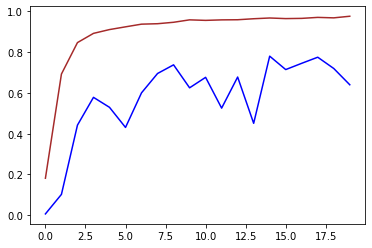

In [105]:
val_accs = baseline_simple_history.history["val_acc"]
train_accs = baseline_simple_history.history["acc"]

plt.plot(val_accs, c = "blue")
plt.plot(train_accs, c = "brown")

plt.show()

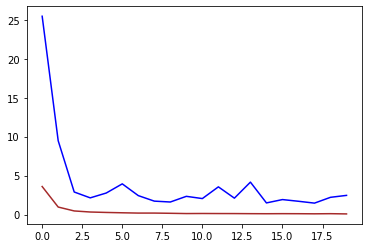

In [106]:
val_loss = baseline_simple_history.history["val_loss"]
train_loss = baseline_simple_history.history["loss"]

plt.plot(val_loss, c = "blue")
plt.plot(train_loss, c = "brown")

plt.show()

# Contrastive learning with simple encoder

In [168]:

class ContrastiveModel(keras.Model):
    def __init__(self, 
                 *, 
                 temperature = 0.1,
                 #encoder,
                 #proj_dims = (500, 300), 
                 #imgaug,
                 #prob_imgaug,
                 ):
        
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = build_augmenter(**contrastive_augmentation)
        self.classification_augmenter = build_augmenter(**classification_augmentation)
        self.encoder = build_simple_encoder()
        
        proj_input_shape = self.encoder.layers[-1].output.shape[1:]
        print("proj_input_shape = ", proj_input_shape)
        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(1000, )),
                layers.Dense(1000, activation="relu"),
                layers.Dense(1000), #pure linear
                #layers.BatchNormalization()
            ],
            name="projection_head",
        )
        
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [
                 layers.InputLayer(input_shape=(1000,)), 
                 layers.Dense(n_classes), #pure linear
            ], 
                 name="linear_probe"
        )

        #self.encoder.summary()
        #self.projection_head.summary()
        #self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

        #self.knn_accuracy = 
        
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        
        
        
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
     
        #unpacking the training images and labels (fake) in the batch
        images,labels = data
    
        
        """ The contrastive learning episode
        
        """
        
        # We randomly sample two transformation functions
        # and use them to augment the input batch (N images).
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        
        
        # We now have 2*N augmented images
        
        
        # tf.GradientTape is a basic facility in tensorflow, which implemented 
        # of recording operations for automatic differentiation..
        #
        # ref: https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # ref:
        
        # Create a GradientTape instance to record the forward process
        with tf.GradientTape() as tape:
            # Feeding augmented images (2*N) into the base encoder
            # to extract their features (2*N)
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            
            # Feeding the features (2*N) into the projection head, which is 
            # a MLP, the final layer is a pure linear layer.
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            
            # We now have 2*N projections from the projection head
            # and compute the contrastive loss (info-NCE)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            
        # Computing the gradients w.r.t. every trainable variables by back-propogating the errors    
        # the *gradients* has the results with the form dL / dW
        gradients = tape.gradient(
            contrastive_loss,
            #[self.encoder.trainable_weights, self.projection_head.trainable_weights],
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        
        # Optimising the weights by the computed gradients.
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                #[self.encoder.trainable_weights, self.projection_head.trainable_weights],
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        
        # Updating the loss history.
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        """ Updating the weights of the linear prediction model
        
        """
                        
        augmented_images_3 = self.classification_augmenter(images)
        
        # Forward
        with tf.GradientTape() as tape:
            
            features = self.encoder(augmented_images_3)
            
            features_2 = self.projection_head(features)
                      
            class_logits = self.linear_probe(features_2)
            
            probe_loss = self.probe_loss(labels, class_logits)
            
            
        # backwards, computing the gradients w.r.t. the linear prober
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        
        # updating the weights.
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        
        # updating history.
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        features_2 = self.projection_head(features, training=False)
        
        class_logits = self.linear_probe(features_2, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


In [169]:
pretraining_model = ContrastiveModel()

# Contrastive pretraining
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

proj_input_shape =  (1000,)


In [170]:
n_epochs = 20
pretraining_history = pretraining_model.fit(
    train_dataset, 
    epochs=n_epochs, 
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/20
121/121 [==============================] - 386s 3s/step - c_loss: 1.0464 - c_acc: 0.9085 - p_loss: 5.0447 - p_acc: 0.0092 - val_p_loss: 5.0282 - val_p_acc: 0.0088
Epoch 2/20
121/121 [==============================] - 369s 3s/step - c_loss: 0.1005 - c_acc: 0.9973 - p_loss: 5.0111 - p_acc: 0.0144 - val_p_loss: 5.0219 - val_p_acc: 0.0119
Epoch 3/20
 15/121 [==>...........................] - ETA: 5:05 - c_loss: 0.0933 - c_acc: 0.9979 - p_loss: 5.0027 - p_acc: 0.0198

KeyboardInterrupt: 

In [ ]:
val_p_acc = max(pretraining_history.history["val_p_acc"]) * 100

p_acc = max(pretraining_history.history["p_acc"]) * 100
c_acc = max(pretraining_history.history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")